# GPT with character level embeddings on small shakespear dataset

# Preprocesing 

1. Tokenize: string -> chars 
2. Numeracilisation: chars -> index 
3. Sample context_length chunks from data.
4. Each context_length chunk has context_length training examples. predict token_i with tokens_{<i}
5. 

In [1]:
# https://www.youtube.com/watch?v=kCc8FmEb1nY&ab_channel=AndrejKarpathy
import torch

# Load dataset
with open("data/shakespear.txt") as fn:
    text = fn.read()

# Get unique lsit
chars = sorted(list(set(text)))

vocab_size = len(chars)
print(chars)
print(len(chars))


['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65


In [2]:
# Tokenize. Chars -> intergers/index
s2i = {ch: i for i, ch in enumerate(chars)}
i2s = {i: ch for i, ch in enumerate(chars)}
encode = lambda x: [s2i[ch] for ch in x]
decode = lambda x: [i2s[i] for i in x]

print(encode("hello"))
print(decode(encode("hello")))


[46, 43, 50, 50, 53]
['h', 'e', 'l', 'l', 'o']


In [3]:
# Tokenize whole training set
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape)
print(data[:1000])

# Train/val
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

torch.Size([1115393])
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57

How we grab an input:

In [4]:
context_length = 8
print(train_data[: context_length + 1])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


Example of how it's auto regressive

In [5]:
x = train_data[:context_length]
y = train_data[1:context_length+1]
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(f"using input {context} the target is : {target}")
    

using input tensor([18]) the target is : 47
using input tensor([18, 47]) the target is : 56
using input tensor([18, 47, 56]) the target is : 57
using input tensor([18, 47, 56, 57]) the target is : 58
using input tensor([18, 47, 56, 57, 58]) the target is : 1
using input tensor([18, 47, 56, 57, 58,  1]) the target is : 15
using input tensor([18, 47, 56, 57, 58,  1, 15]) the target is : 47
using input tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is : 58


sample minibatch: notice input encodes autoregressive style inputs

In [6]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
context_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_size, (batch_size,))
    x = torch.stack([data[i:i+context_size] for i in ix])
    y = torch.stack([data[i+1:i+context_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(context_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])
targets:
torch.Size([4, 8])
tensor([[59,  6,  1, 58, 56, 47, 40, 59],
        [43, 43, 54,  1, 47, 58,  1, 58],
        [52, 45, 43, 50, 53,  8,  0, 26],
        [39,  1, 46, 53, 59, 57, 43,  0]])
----
when input is [53] the target: 59
when input is [53, 59] the target: 6
when input is [53, 59, 6] the target: 1
when input is [53, 59, 6, 1] the target: 58
when input is [53, 59, 6, 1, 58] the target: 56
when input is [53, 59, 6, 1, 58, 56] the target: 47
when input is [53, 59, 6, 1, 58, 56, 47] the target: 40
when input is [53, 59, 6, 1, 58, 56, 47, 40] the target: 59
when input is [49] the target: 43
when input is [49, 43] the target: 43
when input is [49, 43, 43] the target: 54
when input is [49, 43, 43, 54] the target: 1
when input is [49, 43, 43, 54, 1] the target: 47
when input is [49, 43, 

# Bigram model

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers. get the embeddings. 
        # each index in input tensor takes out token_embeeding_table row
        logits = self.token_embedding_table(idx) # (B,T,C)
        B,T,C = logits.shape
        logits = logits.view(B*T, C)
        targets=targets.view(B*T)
        loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb)
print(logits.shape)
print(loss) # expecting ~ -ln(1/65)

torch.Size([32, 65])
tensor(4.8948, grad_fn=<NllLossBackward0>)


Add a generative step. 

In [8]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
            
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None: # targets optional for inference 
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            
            # get most recent token 
            logits = logits[:, -1, :] # becomes (B, C)
            
            # softmax over vocabulary 
            probs = F.softmax(logits, dim=-1) # (B, C)
            
            # sample from the distribution to get next input 
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.7525, grad_fn=<NllLossBackward0>)
['\n', 'h', 'b', 'H', '\n', '\n', ':', 'C', 'L', 'P', '.', 'A', '!', 'f', 'q', "'", '3', 'g', 'g', 't', '!', 'O', '!', 'T', '?', 'X', '!', '!', 'S', 'A', '?', 'W', '&', 'T', 'r', 'p', 'v', 'Y', 'y', 'b', 'S', 'E', '3', 'w', '&', 'S', ' ', 'B', 'X', 'U', 'h', 'm', 'i', 'K', 'Y', 'y', 'T', 'm', 'W', 'M', 'P', 'h', 'h', 'm', 'n', 'H', 'K', 'j', '!', '!', 'b', 't', 'g', 'n', 'w', 'N', 'N', 'U', 'L', 'u', 'E', 'z', 'R', 'u', 'Y', 'y', 'i', 'W', 'E', 'Q', 'x', 'P', 'X', '!', '$', '3', 'C', "'", 'M', 'B', 'j']


In [9]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # 3e-4 for big network. 1e-3 for small networks.  

In [10]:
batch_size = 32
for steps in range(1000):
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())
                    

3.5927720069885254


In [11]:
print("".join(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist())))


MQHMdmCgtwt!ZApKKTw!O DkG3LXZBCUknouca, oy.;JolY h&Uf?wi$NUTB$Rv-FYtABSEQpa-G XpbshbHhGJQw naoGft;RH
veBZLulpFNvXUQonpft$JYWABUYtizXe:Cr,mfGBsut;J!..g'FKMp&H!SQSG..WiswtP n;;fG-Jup:mjCrl-wLI alntQ-R-l oy t!ri?mCIaf.NY tfJ;ppbmzXPaugeUY VDkCth
y3MMqDBLXXZ. hNUwic,b;HoSwaxqDlaS:LzLXHTEH:dzBye tolXc$ sTZE3ggxwm:hnQ!.f?
eU'zBaWivamINahw?:,b
hIxqNzXPnvqf fAz,ETVr'PasU$SEtvNJ!!Twcy M$KMBymbUJOWon n.y;JFviC$q3woByHp t,QHkHkRauTmhiUCWf JI:nsETHeg
QEDdkbYjk:iiIUMK3,Q$b
oVBWhXchbnp,3S-GL.WUXPl.WCj!'z!B$Ei



### Trick for self attention



In [12]:
torch.manual_seed(1337)
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

x[b,t] = mean_{z<=t} x[b,i]... take mean feature vector of history

In [13]:
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b,t] = torch.mean(xprev, 0)

In [14]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [15]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

first is first. second is average of first and second. third is average of frist, second and third

can achieve this loop efficiently with a lower triangular matrix that is normalised along the rows

In [16]:
a = torch.tril(torch.ones(3,3)) 
a = a/ torch.sum(a, 1, keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [17]:
# for above 
a = torch.tril(torch.ones(T,T)) 
a = a/ torch.sum(a, 1, keepdim=True)
xbow2 = a @ x # (B,T,T) @ (B,T,C) ---> (B,T,C)
xbow2

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

In [18]:
torch.allclose(xbow, xbow2)

True

The idea is to switch to a weighted sum where weighting is attention. So this weghting will be learnt. 

## Transformer model 

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class FeedFoward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Head(nn.Module):
    """one head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(context_size, context_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)  # (B,T,hs)
        q = self.query(x)  # (B,T,hs)
        # compute attention scores ("affinities")
        wei = (
            q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        )  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out
    
class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # list of submodules, accesed ilke normal list  
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class Transformer(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class GPT(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)
        self.blocks = nn.Sequential(
            *[Transformer(n_embd, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init
        self.apply(self._init_weights)
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last context_size tokens
            idx_cond = idx[:, -context_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

In [20]:
@torch.no_grad() # no gradient recording 
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            X = X.to(device)
            Y = Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Note:
- @torch.no_grad() # no grad recording, less memory
- model.eval(), model.train() # switching 
- different weight initalisations 
- self.apply() # init weights 
- nn.Sequential(*[Transofrmer() for in ...]) # unpacking argumetns into sequential
- self.register_buffer # non-trainable params in model
- nn.ModuleList # special list for modules 

In [21]:
n_embd = 384 # size of embedding in attnetion
n_layer = 6 # 
n_head = 6 # num heads in multi head attention
batch_size = 256 
context_size = 256 # max input 
learning_rate = 3e-4
eval_iters= 200
eval_interval = 500
max_iters = 5000
dropout = 0.2 # rate of dropout 
device = "cuda"


model = GPT()
model.to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

10.788929 M parameters


In [22]:
device = model.parameters().__next__().device
print("Model device:", device)

Model device: cuda:0


In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # memory used by this? 
for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(
            f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train")
    xb = xb.to(device)
    yb = yb.to(device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2209, val loss 4.2195
step 500: train loss 1.5228, val loss 1.7124
step 1000: train loss 1.2391, val loss 1.5180
step 1500: train loss 1.0989, val loss 1.4956
step 2000: train loss 0.9639, val loss 1.5082
step 2500: train loss 0.8308, val loss 1.5729
step 3000: train loss 0.7059, val loss 1.6486
step 3500: train loss 0.5797, val loss 1.7509
step 4000: train loss 0.4770, val loss 1.8594
step 4500: train loss 0.3877, val loss 1.9613
step 4999: train loss 0.3215, val loss 2.0376
['\n', 'A', 'p', 'o', 'l', 'l', 'o', ',', ' ', 'o', 'u', 'r', ' ', 's', 'o', 'n', ',', ' ', 't', 'a', 'k', 'e', 's', ';', ' ', 'a', 'n', 'd', ' ', 'y', 'o', 'u', 'r', ' ', 'b', 'r', 'o', 't', 'h', 'e', 'r', ' ', 'b', 'e', 'l', 'o', 'w', 's', '.', '\n', 'I', "'", 'l', 'l', ' ', 'h', 'a', 'v', 'e', ' ', 'y', 'o', 'u', ' ', 'a', 'c', 'c', 'o', 's', 't', ' ', 'u', 'p', ' ', 'w', 'i', 't', 'h', ' ', 'b', 'o', 'o', 'k', ' ', 'f', 'o', 'r', 'r', "'", 't', '.', '\n', '\n', 'S', 'I', 'C', 'I', 'N', 'I'

In [25]:
torch.save(model.state_dict(), f"gpt.pth")

In [27]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print("".join(decode(model.generate(context, max_new_tokens=500)[0].tolist())))


Name uname throws, while I did othem
A dream my wife to the morning.

CAMILLO:
I have help'd it so, I am comfort with light
And talk'd of no lesss.

LEONTES:
Thou want'st woman, like men's a desight
In this knace of imagine before my only;
The other of other gawds each parent,
And grift of the houndam, nice, the daught,
When I, there lie hoope to forget through hurough
And old now for the herd life before left our brother.
This shall well usurp the holy seat,
Even was thought, with a foul sorrow


# nn.Embedding layer 

```
emb = nn.Embedding(vocab_size, n_embd)

emb(t) # tensor is arbitary size of num of indexs to extract
```

nn.Embedding is a vocab_size x n_embd matrix. For every element of tensor argument when it's called, the index is extracted from the embedding matrix. 

A common pretraining for these embeddings is glove. But they can be trainable themselves. 

In [47]:
import matplotlib.pyplot as plt
vocab_size = 10
n_embd = 3

embedding = nn.Embedding(10, 3)
inp = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedded = embedding(inp).detach().numpy()
print(f"{inp.numpy().shape} -> {embedded.shape}")

(2, 4) -> (2, 4, 3)


In [58]:
w = embedding.weight.detach().numpy()
print(f"embedding shape = {w.shape}")

embedding shape = (10, 3)


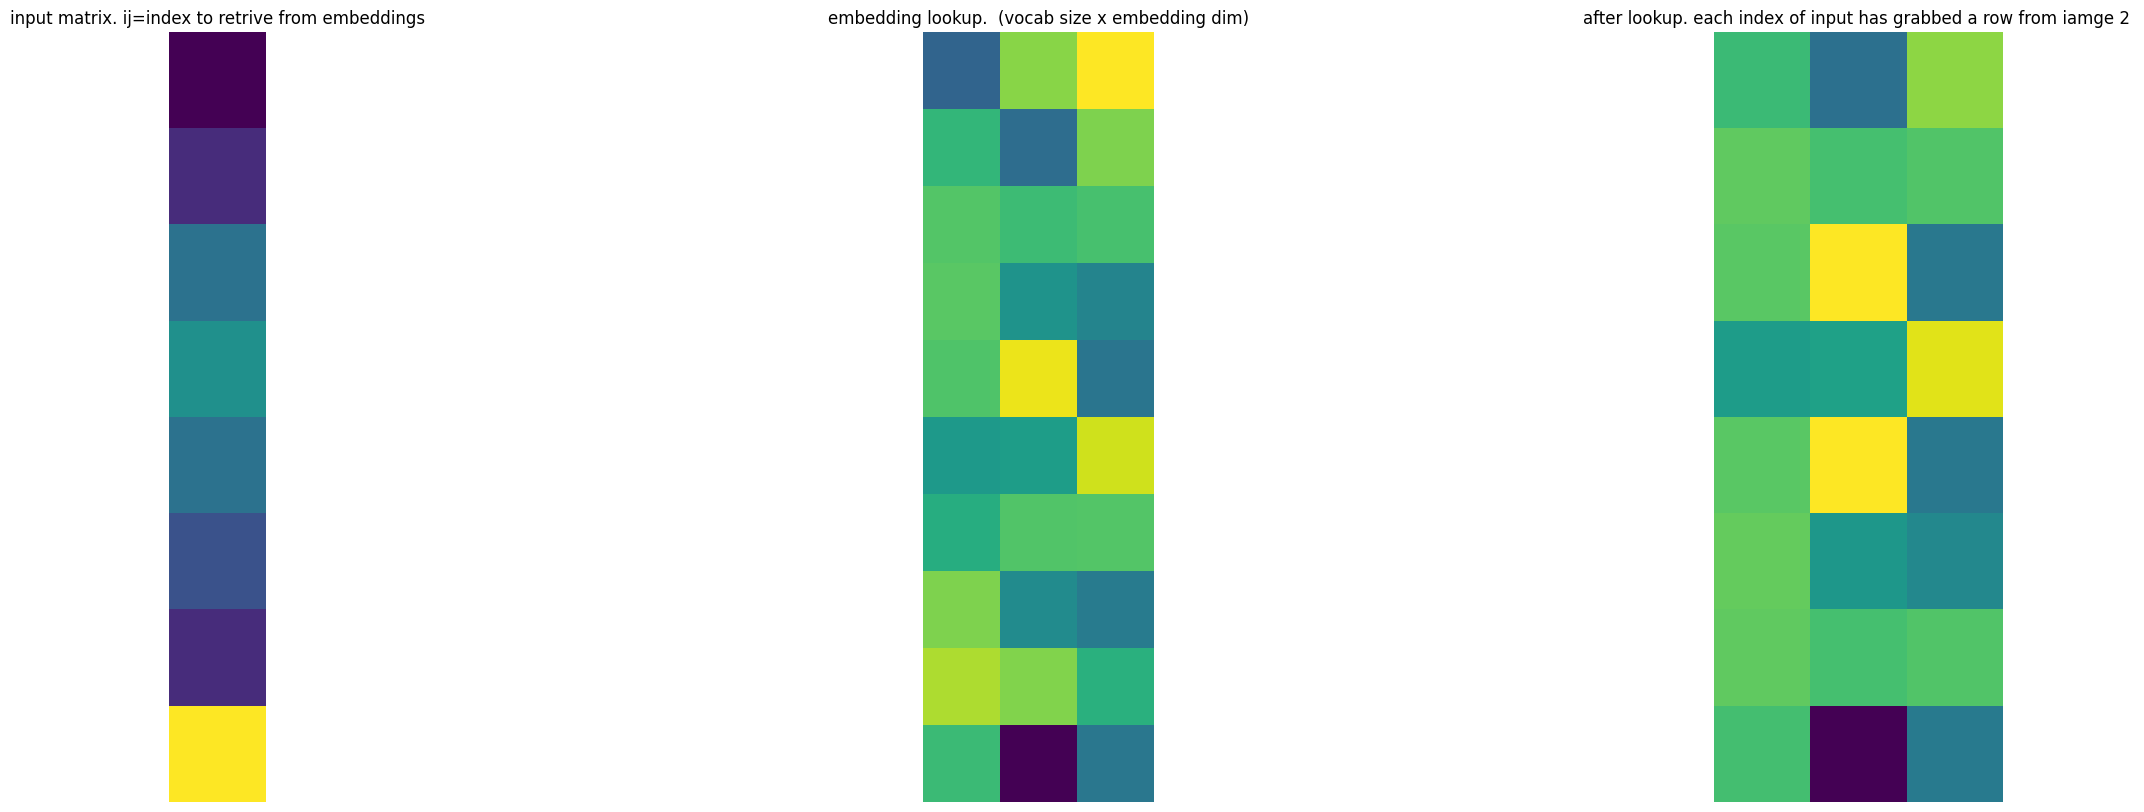

In [73]:
fig, axs = plt.subplots(1,3,figsize=(30,10))
axs[0].imshow(inp.detach().numpy().reshape(8,1))
axs[0].set_title('input matrix. ij=index to retrive from embeddings')
axs[1].imshow(w)
axs[1].set_title('embedding lookup.  (vocab size x embedding dim)')
axs[2].imshow(embedded.reshape(8,3))
axs[2].set_title('after lookup. each index of input has grabbed a row from iamge 2 ')
for ax in axs:
    ax.axis('off')